In [1]:
notebook_path = "Projects/QuantumFlow/notebooks"
try:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)
except:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('../')

from quantumflow.colab_train_utils import load_hyperparameters, test_colab_devices, unpack_dataset
from quantumflow.calculus_utils import integrate_simpson, normalize, predict, functional_derivative

!pip install -q ruamel.yaml

/home/manuel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/manuel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/manuel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/manuel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

/bin/sh: 1: pip: not found


In [2]:
data_dir = "../data"
experiment = 'krr'
run_name = 'default'
base_dir = os.path.join(data_dir, experiment)

if not os.path.exists(os.path.join(data_dir, experiment)): os.makedirs(os.path.join(data_dir, experiment))
file_hyperparams = os.path.join(data_dir, experiment, "hyperparams.config")

In [3]:
%%writefile $file_hyperparams

default: &DEFAULT
    run_name: default
    dataset_train: recreate_paper
    dataset_val: recreate
    N: 1

    lambda_coeff: 12.0E-14
    sigma: 43
    m: 30
    l: 5


Overwriting ../data/krr/hyperparams.config


In [3]:
params = load_hyperparameters(file_hyperparams, run_name=run_name)

with open(os.path.join(data_dir, params['dataset_train'], 'dataset_training.pkl'), 'rb') as f:
    x, potentials, wavefunctions, energies, densities, kenergies, M, G, h = unpack_dataset(params['N'], pickle.load(f))
    
with open(os.path.join(data_dir, params['dataset_val'], 'dataset_testing.pkl'), 'rb') as f:
    _, test_potentials, _, _, test_densities, test_kenergies, M_test, _, _ = unpack_dataset(params['N'], pickle.load(f))

X_train = densities
X_test = test_densities

y_train = kenergies
y_test = test_kenergies

T_mean = np.mean(y_train)

print("T_mean:", T_mean)
print("lambda:", params['lambda_coeff'])
print("sigma:", params['sigma'])

T_mean: 5.430827552437079
lambda: 1.2e-13
sigma: 43


##Kernel Ridge Regression
###Paper:
$$T^{\text{ML}}(\mathbf{n}) = \not{\bar{T}}\sum_{j=1}^{M}\alpha_j k(\mathbf{n}_j, \mathbf{n})$$

$$k(\mathbf{n}, \mathbf{n}') = \text{exp}(-\| \mathbf{n} - \mathbf{n}'\|^2/(2\sigma^2))$$


$$\text{Optimize}:~~~~\mathcal{C}(\mathbf{\alpha}) = \sum_{j=1}^{M}\ (T_j^{\text{ML}} - T_j)^2 + \lambda \|\alpha\|^2$$

---

### Sklearn:

$$T^{\text{ML}}(\mathbf{n}) = 1\sum_{j=1}^{M}\omega_j \tilde{k}(\mathbf{n}_j, \mathbf{n})$$

$$\tilde{k}(\mathbf{n}, \mathbf{n}') =  \text{exp}(-\gamma~\| \mathbf{n} - \mathbf{n}'\|^2)$$

$$\text{Optimize}:~~~~\mathcal{C}(\mathbf{\omega}) = \sum_{j=1}^{M}\ (T_j^{\text{ML}} - T_j)^2 + \tilde{\alpha} \|\omega\|^2$$

---

$$\omega = \bar{T} \alpha$$
$$\gamma = \frac{1}{2\sigma^2}$$
$$\tilde{\alpha} = \frac{1}{\not{\bar{T}}^2} \lambda$$

In [4]:
from sklearn.kernel_ridge import KernelRidge

alpha = params['lambda_coeff']#/(T_mean**2)
gamma = 1/(2*params['sigma']**2)

clf = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
clf.fit(X_train, y_train)

KernelRidge(alpha=1.2e-13, coef0=1, degree=3, gamma=0.00027041644131963225,
            kernel='rbf', kernel_params=None)

In [5]:
y_predict = clf.predict(X_test)
absolute_error = np.abs(y_predict - y_test)
MAE = np.mean(absolute_error)
ae_std = np.std(absolute_error)
ae_max = np.max(absolute_error)

kcalmol_per_hartree = 627.51

print("MAE:", MAE*kcalmol_per_hartree, "kcal/mol")
print("std:", ae_std*kcalmol_per_hartree, "kcal/mol")
print("max:", ae_max*kcalmol_per_hartree, "kcal/mol")

print("\nrelative error:", np.mean(absolute_error/y_test))

MAE: 0.15640985223168297 kcal/mol
std: 0.22635835893181405 kcal/mol
max: 3.266936008494316 kcal/mol

relative error: 4.508549608006345e-05


Kernel Ridge:  [ 1.43487747e+08  5.19176175e+07  8.13025327e+06 -5.37021598e+07] ...
Paper Weights: [ 1.43426716e+08  5.17536085e+07  8.35534193e+06 -5.37380622e+07] ...


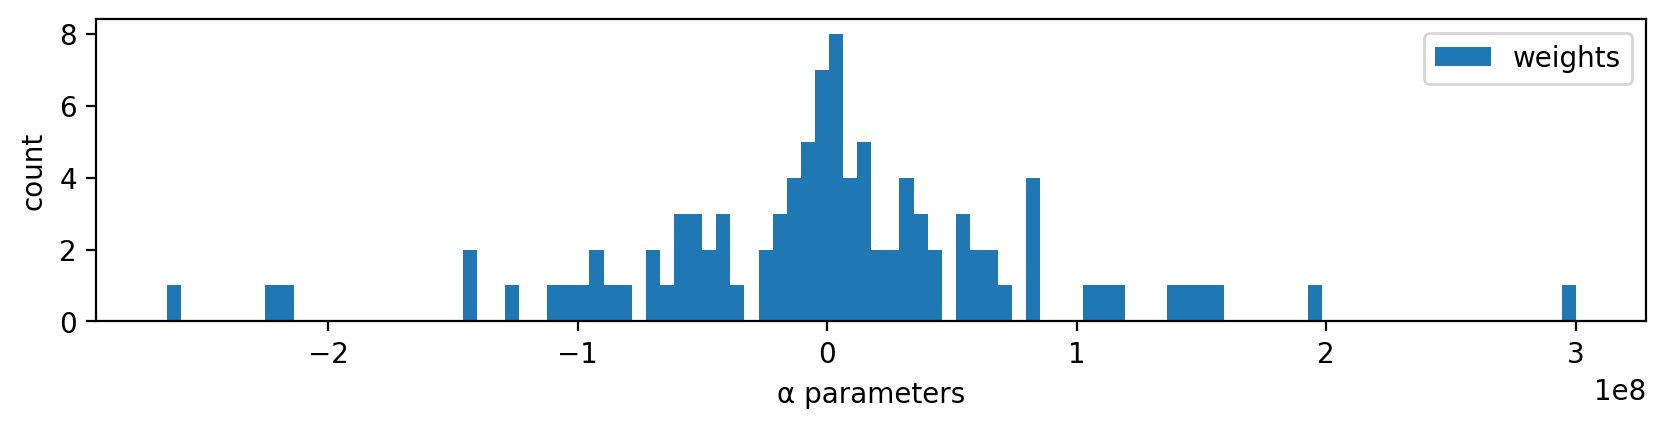

In [16]:
import pandas as pd
paper_weights = 10**7*pd.read_csv('1b_paper_potentials.txt', delimiter=' ')['αj'].values
weights = clf.dual_coef_

print('Kernel Ridge: ', weights[:4], '...')
print('Paper Weights:', paper_weights[:4], '...')

plt.figure(figsize=(10, 2), dpi=200)
plt.hist(weights, bins=100, label="weights")
#plt.title("Distribution of weights")
plt.xlabel('α parameters')
plt.ylabel('count')
plt.legend()
plt.show()

In [18]:
with open(os.path.join(data_dir, experiment, run_name + '.pkl'), 'wb') as f:
    pickle.dump({'X_train': X_train, 'weights': weights}, f)

## functional derivative

$$ \frac{1}{\Delta x} \nabla T^\text{ML}(\mathbf{n}) = \bar{T}\sum_{j=1}^{M}\alpha_j'(\mathbf{n}_j - \mathbf{n})k(\mathbf{n}_j, \mathbf{n}) = -\frac{1}{h} \sum_{j=1}^{M}\omega_j \gamma 2(\mathbf{n} - \mathbf{n}_j)k(\mathbf{n}_j, \mathbf{n})$$

In [19]:
with open(os.path.join(data_dir, 'recreate_paper', 'dataset_sample.pkl'), 'rb') as f:
    x_sample, potential_sample, wavefunction_sample, energies_sample, density_sample, kenergies_sample, _, G, h = unpack_dataset(params['N'], pickle.load(f))

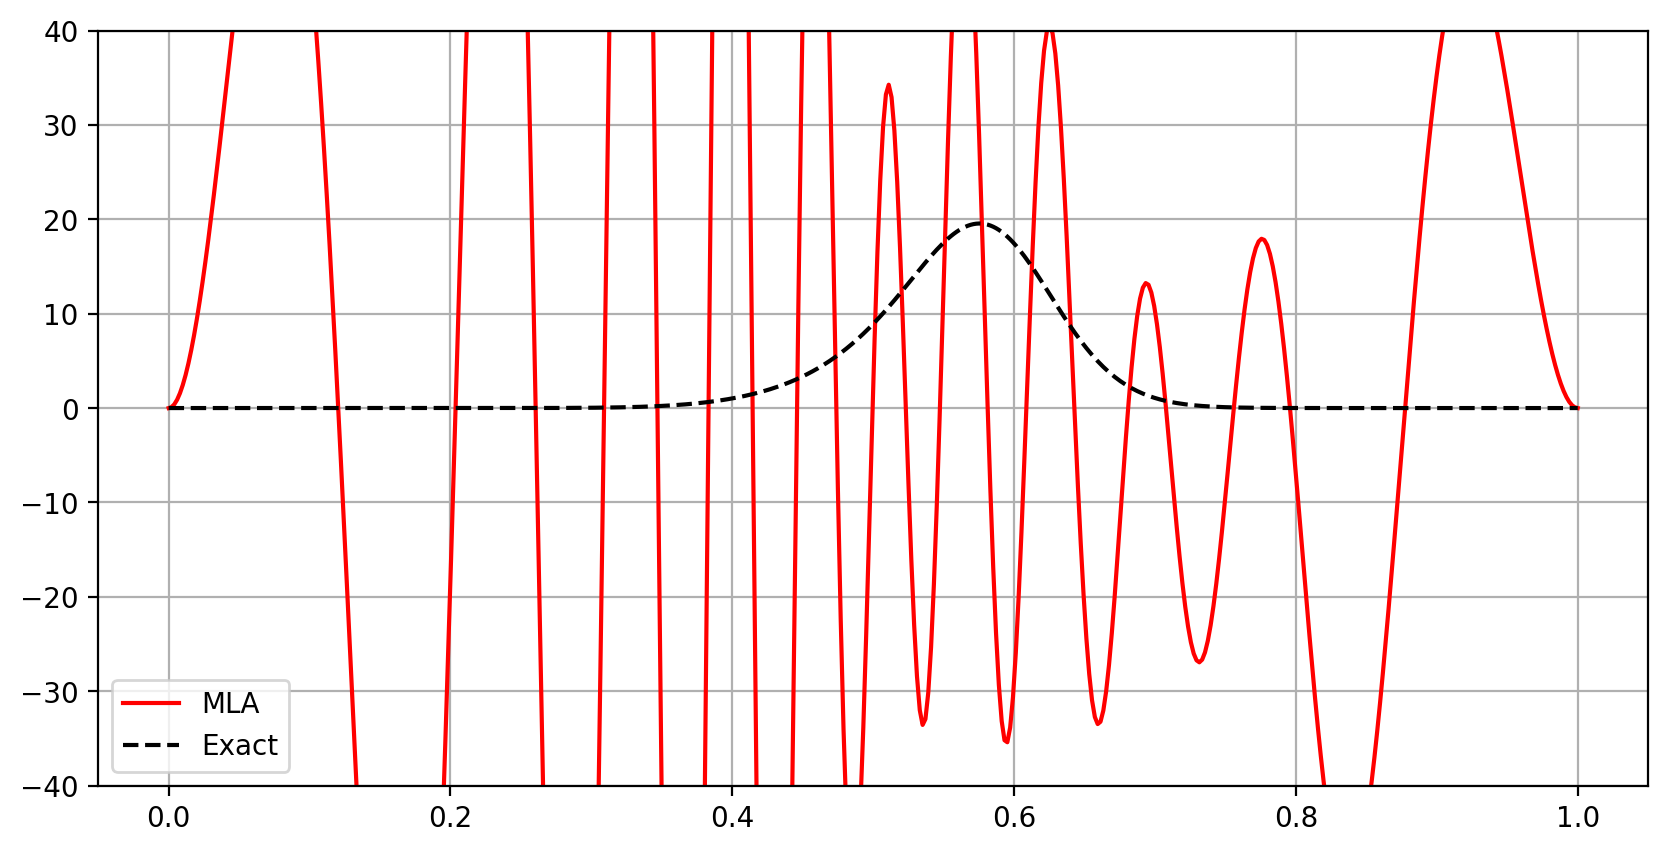

In [20]:
X_sample = density_sample

f_deriv = functional_derivative(X_sample, X_train, weights, gamma, h)[0, :]
f_deriv_paper = functional_derivative(X_sample, X_train, paper_weights, gamma, h)[0, :]

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x, f_deriv, 'r')
plt.plot(x, -potential_sample[0], '--k')
plt.ylim([-40, 40])
plt.grid(True)
plt.legend(['MLA', 'Exact'])
plt.show()

## PCA

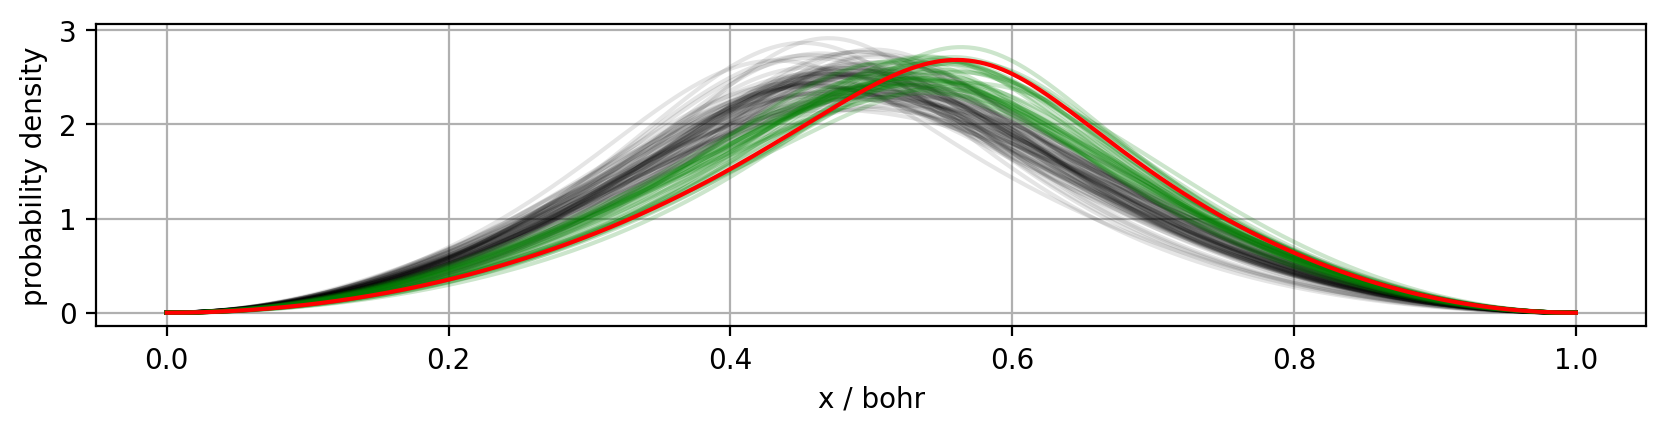

In [37]:
m = params['m']

norm_closest = np.sum(np.square(X_sample - X_train), -1)
idx = np.argpartition(norm_closest, m)
X_closest = X_train[idx[:m]]

plt.figure(figsize=(10, 2), dpi=200)
#plt.plot(x, X_sample[0], 'r')
#plt.plot(x, X_closest[0:1, :].transpose(), 'g', alpha=0.8)
plt.plot(x, X_train[idx[m:]].transpose(), 'k', alpha=0.1)#, alpha=0.8)
plt.plot(x, X_closest.transpose(), 'g', alpha=0.2)
plt.plot(x, X_sample[0], 'r')
plt.grid()
plt.xlabel('x / bohr')
plt.ylabel('probability density')
#plt.legend(['sample density', 'nearest m densities', 'all training densities'])
plt.show()

In [38]:
l = params['l']
X = X_sample - X_closest
C = np.matmul(np.transpose(X), X)/m

eigen_vals, eigen_vecs = np.linalg.eig(C)
eigen_vals = np.real(eigen_vals)
eigen_vecs = np.real(eigen_vecs)

select_eigen_vecs = eigen_vecs[:, :l]
P_ml = np.matmul(select_eigen_vecs, np.transpose(select_eigen_vecs))

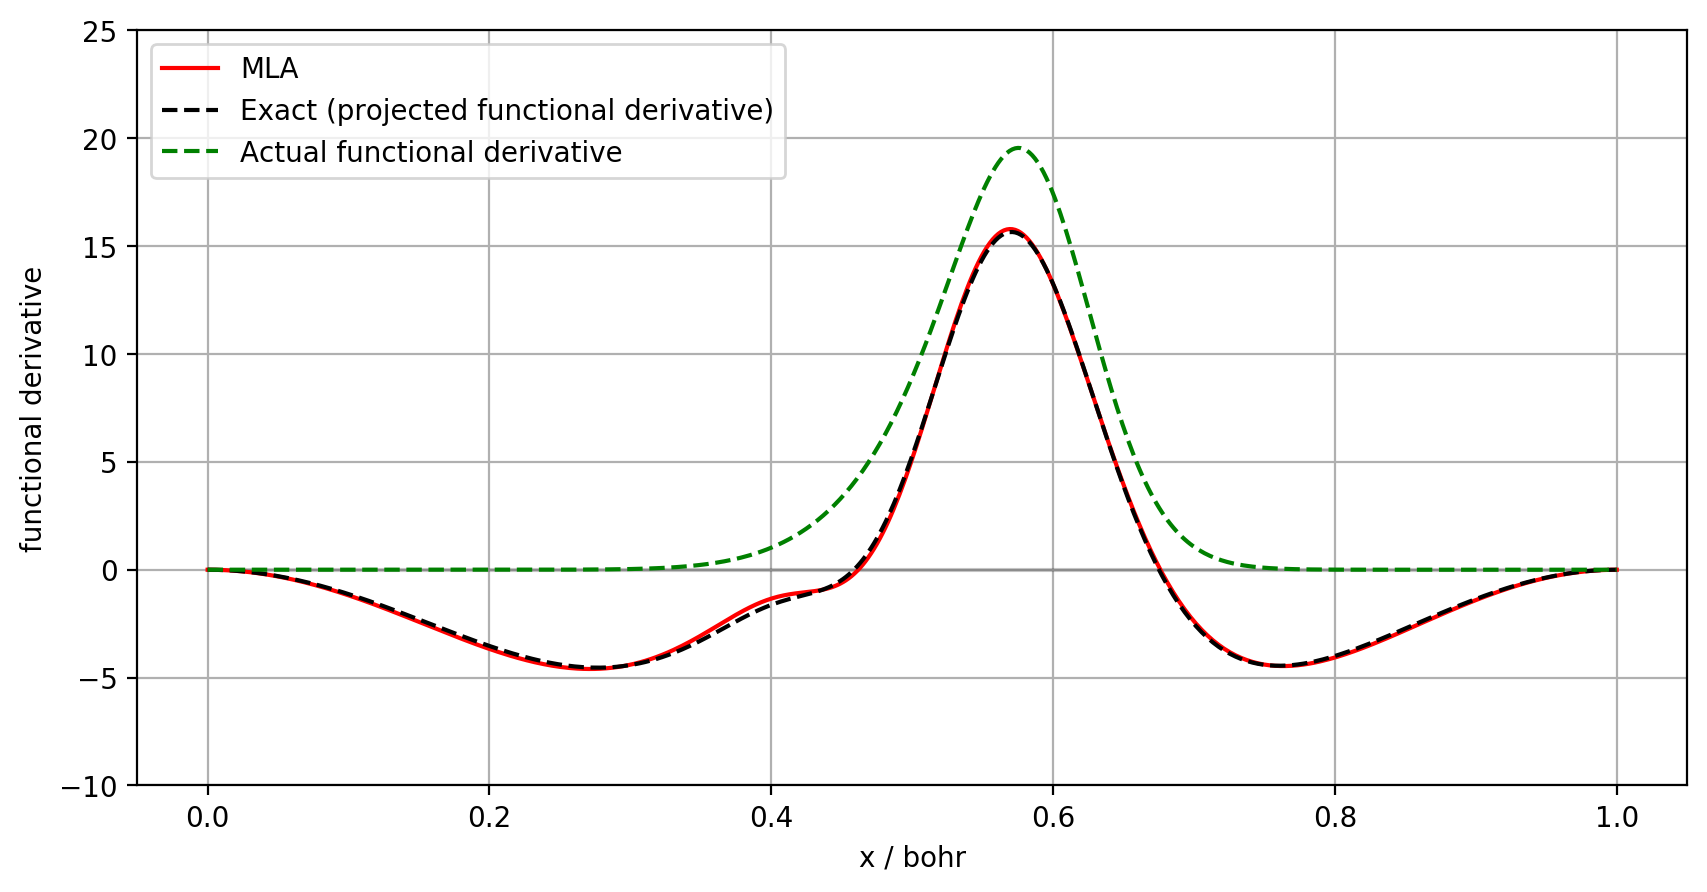

In [42]:
f_deriv_proj = np.matmul(P_ml, f_deriv)
f_deriv_paper_proj = np.matmul(P_ml, f_deriv_paper)
potential_proj = np.matmul(P_ml, -potential_sample[0])

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(x, np.zeros_like(x), 'k', alpha=0.2)
plt.plot(x, f_deriv_proj, 'r', label="MLA")
plt.plot(x, potential_proj, '--k', label='Exact (projected functional derivative)')
plt.plot(x, -potential_sample[0], '--g', label='Actual functional derivative')
plt.ylim([-10, 25])
plt.xlabel('x / bohr')
plt.ylabel('functional derivative')
plt.legend(loc="best")
plt.grid()
plt.show()